In [1]:
import boto3
import pandas as pd
import ast
import json
import matplotlib.pyplot as plt
import time
import torch
import torch.nn.functional as F
import numpy as np
import copy
# from transformers import pipeline, AutoTokenizer, AutoModelForCausalLM, AutoModelForTokenClassification, AutoModel
import os
from sklearn.metrics import roc_curve, auc, precision_recall_curve
# from huggingface_hub import login
# from sentence_transformers import SentenceTransformer


# Configure pandas to display all columns and their full content without truncation
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.max_colwidth', None)  # Do not truncate column contents
pd.set_option('display.expand_frame_repr', False)  # Avoid wrapping to the next line

## load questions and sql queries in spider train

In [2]:
# Define your S3 bucket and file key
bucket_name = 'sagemaker-studio-423623869859-3no3d9ie4hx'

# Initialize the S3 client
s3_client = boto3.client('s3')

# Load the file from S3
obj = s3_client.get_object(Bucket=bucket_name, Key='df_question_entities_tables.csv')
df_question_entities_tables = pd.read_csv(obj['Body'])
columns_whose_values_are_lists = ['entities_for_tables', 'entities_for_columns', 'tables', 'entities']
for column in columns_whose_values_are_lists:
    df_question_entities_tables[column] = df_question_entities_tables[column].apply(ast.literal_eval)

obj = s3_client.get_object(Bucket=bucket_name, Key='df_schema_table.csv')
df_schema_table = pd.read_csv(obj['Body'])

obj = s3_client.get_object(Bucket=bucket_name, Key='embeddings.json')
embedded_dict = json.load(obj['Body'])
for key in embedded_dict:
    embedded_dict[key] = np.array(embedded_dict[key])

In [3]:
ct = 0
ct_max = 5
for key in embedded_dict:
    print(key)
    print(len(embedded_dict[key]))
    ct += 1
    if ct == ct_max:
        break

what is the first name and last name employee helps the customer with first name leonie?
768
number of bedrooms
768
what are the title and director of the films without any schedule?
768
uganda
768
art instructors
768


In [4]:
df_question_entities_tables.shape

(7000, 6)

In [5]:
df_question_entities_tables.sample(frac=1)[['entities_for_tables', 'tables']].head(10)

,entities_for_tables,tables
5097,[customers],[CUSTOMERS]
1495,[debates],[debate]
5338,[products],"[Manufacturers, products]"
6600,[stations],[station]
2668,[parties],[party]
6873,[routes],"[routes, airports]"
6059,[orders],[order_items]
2824,[restaurant],[Restaurant_Type]
756,[tracks],[track]
450,[allergy],[Allergy_type]


In [6]:
df_schema_table.shape

(749, 5)

In [7]:
df_schema_table.head(3)

,database,table,processed_database,processed_table,database_and_table
0,academic,author,academic,author,academic author
1,academic,conference,academic,conference,academic conference
2,academic,domain,academic,domain,academic domain


## get corpus for retrieval

In [8]:
all_tables = []
for ind, row in df_question_entities_tables.iterrows():
    all_tables += row['tables']
    
all_tables = list(set(all_tables))
all_tables = [[ele] for ele in all_tables]
df_all_tables = pd.DataFrame(all_tables, columns=['table'])
df_all_tables['processed_table'] = df_all_tables['table'].apply(lambda x: ' '.join(segment for segment in x.split('_') if not segment.isdigit())
)
df_all_tables['processed_table'] = df_all_tables['processed_table'].apply(lambda x : x.lower())
df_all_tables['embedding'] = df_all_tables['processed_table'].map(embedded_dict)
df_all_tables.isna().sum()

table              0
processed_table    0
embedding          0
dtype: int64

In [9]:
search_corpus = df_all_tables[['embedding', 'processed_table', 'table']]\
.drop_duplicates(subset=['table']).values.tolist()

In [10]:
def cosine_similarity(vec1, vec2):
    
    dot_product = np.dot(vec1, vec2)
    norm_a = np.linalg.norm(vec1)
    norm_b = np.linalg.norm(vec2)
    
    # Calculate cosine similarity
    result = dot_product / (norm_a * norm_b)
    return result

def search_for_a_single_entity(entity, search_corpus, embedded_dict):
    
    entity = entity.lower()
    search_corpus_copy = copy.deepcopy(search_corpus)
    entity_embedding = embedded_dict[entity]
    for ind, ele in enumerate(search_corpus_copy):
        document_embedding = ele[0]
        search_corpus_copy[ind].append(cosine_similarity(entity_embedding, document_embedding))
    return search_corpus_copy

def merge_and_sort_multiple_search_corpus_copies(list_of_search_corpus_copies):
    
    if list_of_search_corpus_copies == []:
        return None
    
    result = []
    for ind, ele in enumerate(list_of_search_corpus_copies[0]):
        result.append([])
        for search_corpus_copy in list_of_search_corpus_copies:
            result[-1].append(search_corpus_copy[ind][-1])
            
    search_corpus_copy_merged_and_sorted = []
    #print(result)
    for ind, ele in enumerate(list_of_search_corpus_copies[0]):
        search_corpus_copy_merged_and_sorted.append(ele[:-1]+[max(result[ind])])
        
    search_corpus_copy_merged_and_sorted.sort(key=lambda x: x[-1], reverse=True)
        
    return search_corpus_copy_merged_and_sorted
        

def find_index_of_a_table_from_ranked_list(target_table, search_corpus_copy_merged_and_sorted):
    
    if not search_corpus_copy_merged_and_sorted:
        return None
    
    list_of_sorted_tables = [ele[2] for ele in search_corpus_copy_merged_and_sorted]
    try:
        index = list_of_sorted_tables.index(target_table)
    except:
        index = None
        
    return index

def generate_list_of_similarity_scores_and_truth_labels(ground_truth_tables, search_corpus_copy_merged_and_sorted):
    
    list_of_similarity_scores_and_truth_labels = []
    for ele in search_corpus_copy_merged_and_sorted:
        table = ele[-2]
        similarity_score = ele[-1]
        if table in ground_truth_tables:
            list_of_similarity_scores_and_truth_labels.append([similarity_score, 1])
        else:
            list_of_similarity_scores_and_truth_labels.append([similarity_score, 0])
    
    return list_of_similarity_scores_and_truth_labels

####################################################################################################


df_question_entities_tables['ground_truth_table_indices'] = None
df_question_entities_tables['scores_and_truth_labels'] = None

for ind, row in df_question_entities_tables.iterrows():
    
    if ind % 1000 == 999:
        print(ind)
        
    ground_truth_tables = row['tables']
    entities_for_tables = row['entities_for_tables']
    list_of_search_corpus_copies = []
    
    if entities_for_tables == []:
        print('no entities for tables')
    for entity in entities_for_tables:
        list_of_search_corpus_copies.append(search_for_a_single_entity(entity, search_corpus, embedded_dict))
        
    search_corpus_copy_merged_and_sorted = merge_and_sort_multiple_search_corpus_copies(list_of_search_corpus_copies)
    #print(type(ground_truth_tables))
    
    ground_truth_table_indices = []
    #print(ground_truth_tables)
    flag_found_indices_for_all_ground_truth_tables = True
    for ground_truth_table in ground_truth_tables:
        index = find_index_of_a_table_from_ranked_list(ground_truth_table, search_corpus_copy_merged_and_sorted)
        ground_truth_table_indices.append(index)
        # index would be none if no entities for tables from the original question
        if index is None:
            print('index is None')
            flag_found_indices_for_all_ground_truth_tables = False
            break  
    if flag_found_indices_for_all_ground_truth_tables:  
        df_question_entities_tables.loc[ind, 'ground_truth_table_indices'] = ground_truth_table_indices
        list_of_similarity_scores_and_truth_labels = \
        generate_list_of_similarity_scores_and_truth_labels(ground_truth_tables, search_corpus_copy_merged_and_sorted)
        df_question_entities_tables.loc[ind, 'scores_and_truth_labels'] = list_of_similarity_scores_and_truth_labels
    else:
        continue

no entities for tables
index is None
no entities for tables
index is None
no entities for tables
index is None
no entities for tables
index is None
999
1999
no entities for tables
index is None
2999
3999
4999
5999
no entities for tables
index is None
6999


In [11]:
corpus_size = len(search_corpus)
corpus_size

616

In [12]:
df_question_entities_tables.sample(frac=1)[['entities_for_tables', 'tables', 'ground_truth_table_indices']].head(10)

,entities_for_tables,tables,ground_truth_table_indices
5922,"[tourist attractions, royal family]","[TOURIST_ATTRACTIONS, ROYAL_FAMILY]","[2, 1]"
1066,"[teams, match seasons]",[match_season],[0]
5099,[customer],[CUSTOMERS],[3]
6127,[order],"[customers, customer_orders]","[67, 8]"
1592,"[account, transactions]",[Financial_transactions],[6]
2158,[races],[races],[0]
372,[employees],[Employee],[4]
1883,[elimination],[elimination],[1]
6705,[lessons],"[Staff, Lessons]","[166, 0]"
2634,[rooms],[Rooms],[0]


In [13]:
df_question_entities_tables.shape

(7000, 8)

In [14]:
df_question_entities_tables['ground_truth_table_indices'].isna().sum()

6

In [15]:
df_question_entities_tables_not_null = df_question_entities_tables.loc[~df_question_entities_tables['ground_truth_table_indices'].isna()]

In [16]:
df_question_entities_tables_not_null.shape

(6994, 8)

In [17]:
# Create new columns safely without triggering a SettingWithCopyWarning
df_question_entities_tables_not_null = df_question_entities_tables_not_null.copy()

# Calculate "min_percentile" and "max_percentile"
df_question_entities_tables_not_null["min_percentile"] = df_question_entities_tables_not_null[
    "ground_truth_table_indices"
].apply(lambda x: min(x) / corpus_size)

df_question_entities_tables_not_null["max_percentile"] = df_question_entities_tables_not_null[
    "ground_truth_table_indices"
].apply(lambda x: max(x) / corpus_size)

## look at one single example

In [18]:
question_entity = 'employees'
aaa = search_for_a_single_entity(question_entity, search_corpus, embedded_dict)
aaa.sort(key=lambda x: x[-1], reverse=True)
df_aaa = pd.DataFrame([ele[1:] for ele in aaa][:10], columns=['processed_table', 'table', 'similarity_score'])
df_aaa['question_entity'] = question_entity
df_aaa[['processed_table', 'question_entity', 'table', 'similarity_score']]

,processed_table,question_entity,table,similarity_score
0,employees,employees,Employees,1.000000
1,employees,employees,employees,1.000000
2,employee,employees,EMPLOYEE,0.782726
3,employee,employees,employee,0.782726
4,employee,employees,Employee,0.782726
5,staff,employees,STAFF,0.734211
6,staff,employees,Staff,0.734211
7,staff,employees,staff,0.734211
8,customers,employees,Customers,0.655316
9,customers,employees,CUSTOMERS,0.655316


## evaluation metrics for retrieval

In [19]:
df_question_entities_tables_not_null.columns

Index(['question', 'entities_for_tables', 'entities_for_columns', 'query',
       'tables', 'entities', 'ground_truth_table_indices',
       'scores_and_truth_labels', 'min_percentile', 'max_percentile'],
      dtype='object')

In [20]:
df_question_entities_tables_not_null.sample(frac=1, random_state=14)\
[['question', 'entities_for_tables', 'entities_for_columns',\
  'tables', 'ground_truth_table_indices', 'min_percentile', 'max_percentile']].head(10)

,question,entities_for_tables,entities_for_columns,tables,ground_truth_table_indices,min_percentile,max_percentile
6228,"Find the name, class and rank of all captains.",[captains],"[name, class, rank]",[captain],[0],0.000000,0.000000
5649,Show the countries that have both managers of age above 50 and managers of age below 46.,"[countries, managers]",[age],[manager],[2],0.003247,0.003247
792,Find the ids and names of members who are under age 30 or with black membership card.,[members],"[ids, names, age, membership card]",[member],[1],0.001623,0.001623
1265,Return each apartment type code along with the maximum and minimum number of rooms among each type.,[apartment],"[type code, number of rooms]",[Apartments],[0],0.000000,0.000000
5501,How many students does each advisor have?,"[students, advisor]",[count],[STUDENT],[4],0.006494,0.006494
3527,"display the full name (first and last name), and salary of those employees who working in any department located in London.","[employees, departments]","[full name, first name, last name, salary, department, location]","[departments, locations, employees]","[2, 161, 1]",0.001623,0.261364
6696,List all payment methods and number of payments using each payment methods.,[payment],"[payment methods, number of payments]",[Customer_Payments],[3],0.004870,0.004870
5405,What are the names for the 3 branches that have the most memberships?,"[branches, memberships]",[names],[branch],[0],0.000000,0.000000
746,"What are the different account ids that have made financial transactions, as well as how many transactions correspond to each?","[financial transactions, accounts]","[account ids, transactions]",[Financial_transactions],[1],0.001623,0.001623
1659,What is the average and minimum age of all artists from United States.,[artists],"[age, United States]",[artist],[2],0.003247,0.003247


In [21]:
corpus_size

616

In [22]:
def calculate_quantiles(df, quantile_steps=0.1):

    # Select numeric columns only
    numeric_columns = df.select_dtypes(include=[np.number])
    
    # Calculate quantiles
    quantiles = numeric_columns.quantile(
        q=np.arange(0, 1 + quantile_steps, quantile_steps), axis=0, numeric_only=True
    )
    quantiles.index = [f"{int(q * 100)}%" for q in quantiles.index]  # Format index as percentages
    quantiles = (quantiles * 100).round(3).astype(str) + "%"  # Convert values to percentages and append '%'
    return quantiles

# Calculate quantiles with 10% steps
quantiles_df = calculate_quantiles(df_question_entities_tables_not_null, quantile_steps=0.1)

# Display the quantiles DataFrame
print(quantiles_df)

     min_percentile max_percentile
0%             0.0%           0.0%
10%            0.0%           0.0%
20%            0.0%           0.0%
30%            0.0%         0.162%
40%            0.0%         0.325%
50%          0.162%         0.487%
60%          0.162%         0.974%
70%          0.325%         2.273%
80%          0.649%        10.065%
90%          1.299%        36.477%
100%        94.481%        99.675%


## AUC-ROC and AUC-PRC

In [23]:
all_scores_and_labels = []

for ind, row in df_question_entities_tables_not_null.iterrows():
    one_example_scores_and_labels = row['scores_and_truth_labels']
    all_scores_and_labels += one_example_scores_and_labels

In [24]:
all_scores_and_labels[:5]

[[0.9999999999999999, 0],
 [0.9006696519454702, 0],
 [0.9006696519454702, 0],
 [0.6417659648764319, 0],
 [0.6417659648764319, 0]]

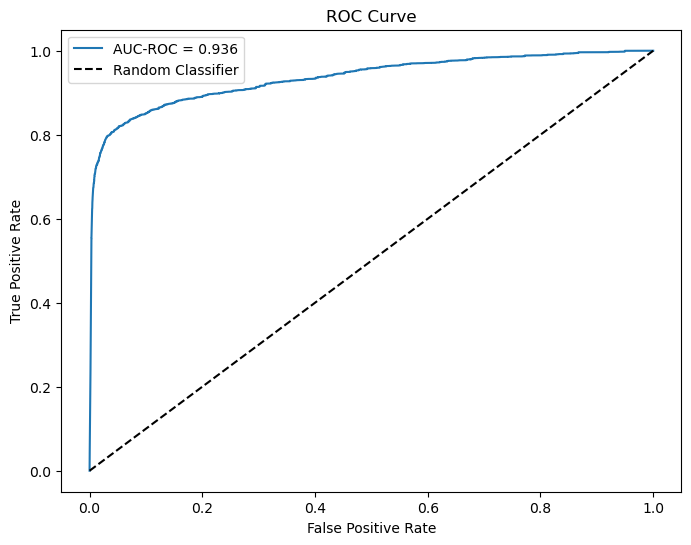

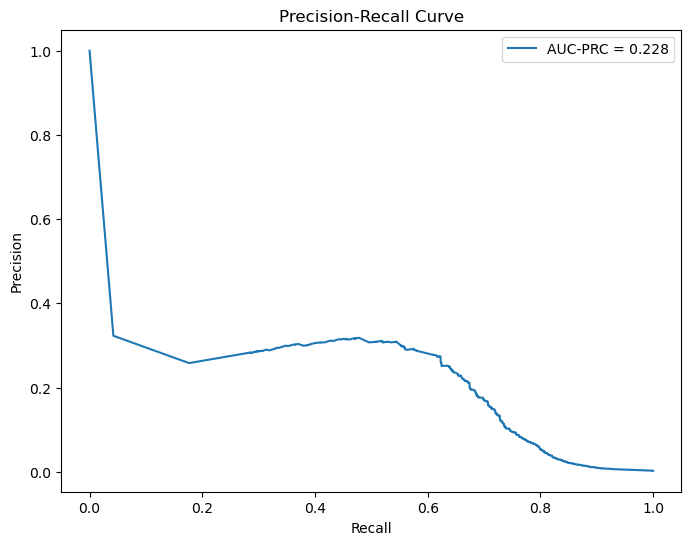

{'Balance Ratio': 0.0025288373336700472,
 'AUC-ROC': 0.9355786425615343,
 'AUC-PRC': 0.22793425480806717,
 'AUC-PRC/balance_ratio': 90.0,
 'Precision at 90.0% recall': '1.0%'}

In [25]:
def evaluate_model(predictions):
    """
    Evaluate model predictions by calculating and plotting:
    1. Balance ratio
    2. ROC curve and AUC-ROC
    3. Precision-Recall curve and AUC-PRC
    4. Precision when recall > 0.95
    
    Args:
        predictions (list of lists): A list where each entry is [score, true_label].

    Returns:
        dict: Dictionary containing balance ratio, AUC-ROC, AUC-PRC, and precision when recall > 0.95.
    """
    # Separate scores and true labels
    y_scores = [item[0] for item in predictions]
    y_true = [item[1] for item in predictions]
    
    # Calculate balance ratio
    balance_ratio = sum(y_true) / len(y_true)
    
    # Calculate ROC curve and AUC-ROC
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)
    
    # Plot ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f"AUC-ROC = {roc_auc:.3f}")
    plt.plot([0, 1], [0, 1], 'k--', label="Random Classifier")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend()
    plt.show()
    
    # Calculate Precision-Recall curve and AUC-PRC
    precision, recall, _ = precision_recall_curve(y_true, y_scores)
    prc_auc = auc(recall, precision)
    
    # Reverse precision and recall for ascending recall order
    precision = precision[::-1]
    recall = recall[::-1]
    
    # Find precision when recall > 0.95
    threshold_recall = 0.9
    precision_at_threshold_recall = None
    for p, r in zip(precision, recall):
        if r > threshold_recall:
            precision_at_threshold_recall = p
            break
    
    # Plot Precision-Recall curve
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, label=f"AUC-PRC = {prc_auc:.3f}")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve")
    plt.legend()
    plt.show()
    
    # Return results
    return {
        "Balance Ratio": balance_ratio,
        "AUC-ROC": roc_auc,
        "AUC-PRC": prc_auc,
        "AUC-PRC/balance_ratio": round(prc_auc / balance_ratio, 0),
        "Precision at {}% recall".format(threshold_recall*100): str(round(precision_at_threshold_recall*100,1))+'%'
    }

evaluate_model(all_scores_and_labels)

## save result as .csv and upload to S3

In [26]:
# Save the DataFrame to a local CSV file
file_name = 'df_question_entities_tables_not_null_v2.csv'
df_question_entities_tables_not_null.to_csv(file_name, index=False, header=True)

# Upload the CSV file to the specified S3 bucket
s3_client.upload_file(file_name, bucket_name, file_name)

print(f"File {file_name} successfully uploaded to s3://{bucket_name}/{file_name}")

File df_question_entities_tables_not_null_v2.csv successfully uploaded to s3://sagemaker-studio-423623869859-3no3d9ie4hx/df_question_entities_tables_not_null_v2.csv
